# Phase 2-2 : 小規模な知識グラフを作ってみる 【SpaCy】

このノートブックでは、spaCy を使って古典的NLPによるトリプルの抽出を試す。

## 目標

- 機械的なトリプル作成の基礎を理解する

## 参考

- [NetworkX](https://networkx.org/documentation/stable/reference/index.html)
- [spaCy](https://spacy.io/)

## ライブラリのインポート

In [17]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
nlp = spacy.load("en_core_web_sm")  # モデルのロード

## サンプルテキスト

In [4]:
texts = [
    "Logistic Regression is a model widely used for binary classification.",
    "Random Forest is an ensemble model of many decision trees.",
    "Transformer is a model based on the attention mechanism.",
    "GPT is a Transformer-based model that uses only the decoder block.",
]

In [5]:
doc = nlp(texts[0])

In [6]:
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['Logistic Regression', 'a model', 'binary classification']
Verbs: ['use']
Logistic Regression ORG


In [7]:
doc

Logistic Regression is a model widely used for binary classification.

In [8]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Logistic Logistic PROPN NNP compound Xxxxx True False
Regression Regression PROPN NNP nsubj Xxxxx True False
is be AUX VBZ ROOT xx True True
a a DET DT det x True True
model model NOUN NN attr xxxx True False
widely widely ADV RB advmod xxxx True False
used use VERB VBN acl xxxx True True
for for ADP IN prep xxx True True
binary binary ADJ JJ amod xxxx True False
classification classification NOUN NN pobj xxxx True False
. . PUNCT . punct . False False


## spaCy を使ったトリプルの抽出

別途関数を用意している

- `src/spacy_helper.py`
    - `get_noun_phrase_map` : ひとまとまりの名詞句を抽出する
    - `get_svo_from_sentence` : 1文のSVOのトリプルを抽出

In [9]:
import sys
sys.path.insert(0, '../')

from src.spacy_helper import get_noun_phrase_map, get_svo_from_sentence

In [15]:
def extract_triples(doc):
    noun_map = get_noun_phrase_map(doc)
    triples = []

    for sent in doc.sents:
        sent_triples = get_svo_from_sentence(sent, noun_map)
        triples.extend(sent_triples)

    return triples

In [16]:
plain_doc = " ".join(texts)
doc = nlp(plain_doc)

triples = extract_triples(doc)

for trp in triples:
    print(trp)

{'subject': 'Logistic Regression', 'verb': 'be', 'object': 'model'}
{'subject': 'model', 'verb': 'use_for', 'object': 'binary classification'}
{'subject': 'Random Forest', 'verb': 'be', 'object': 'ensemble model'}
{'subject': 'Transformer', 'verb': 'be', 'object': 'model'}
{'subject': 'model', 'verb': 'base_on', 'object': 'attention mechanism'}
{'subject': 'GPT', 'verb': 'be', 'object': 'base model'}


## 抽出したトリプルを使って知識グラフを作る

In [18]:
G = nx.DiGraph()  # 有向グラフ。知識グラフは方向性がある

for triple in triples:
    s, p, o = triple["subject"], triple["verb"], triple["object"]
    G.add_node(s)
    G.add_node(o)
    G.add_edge(s, o, relation=p)

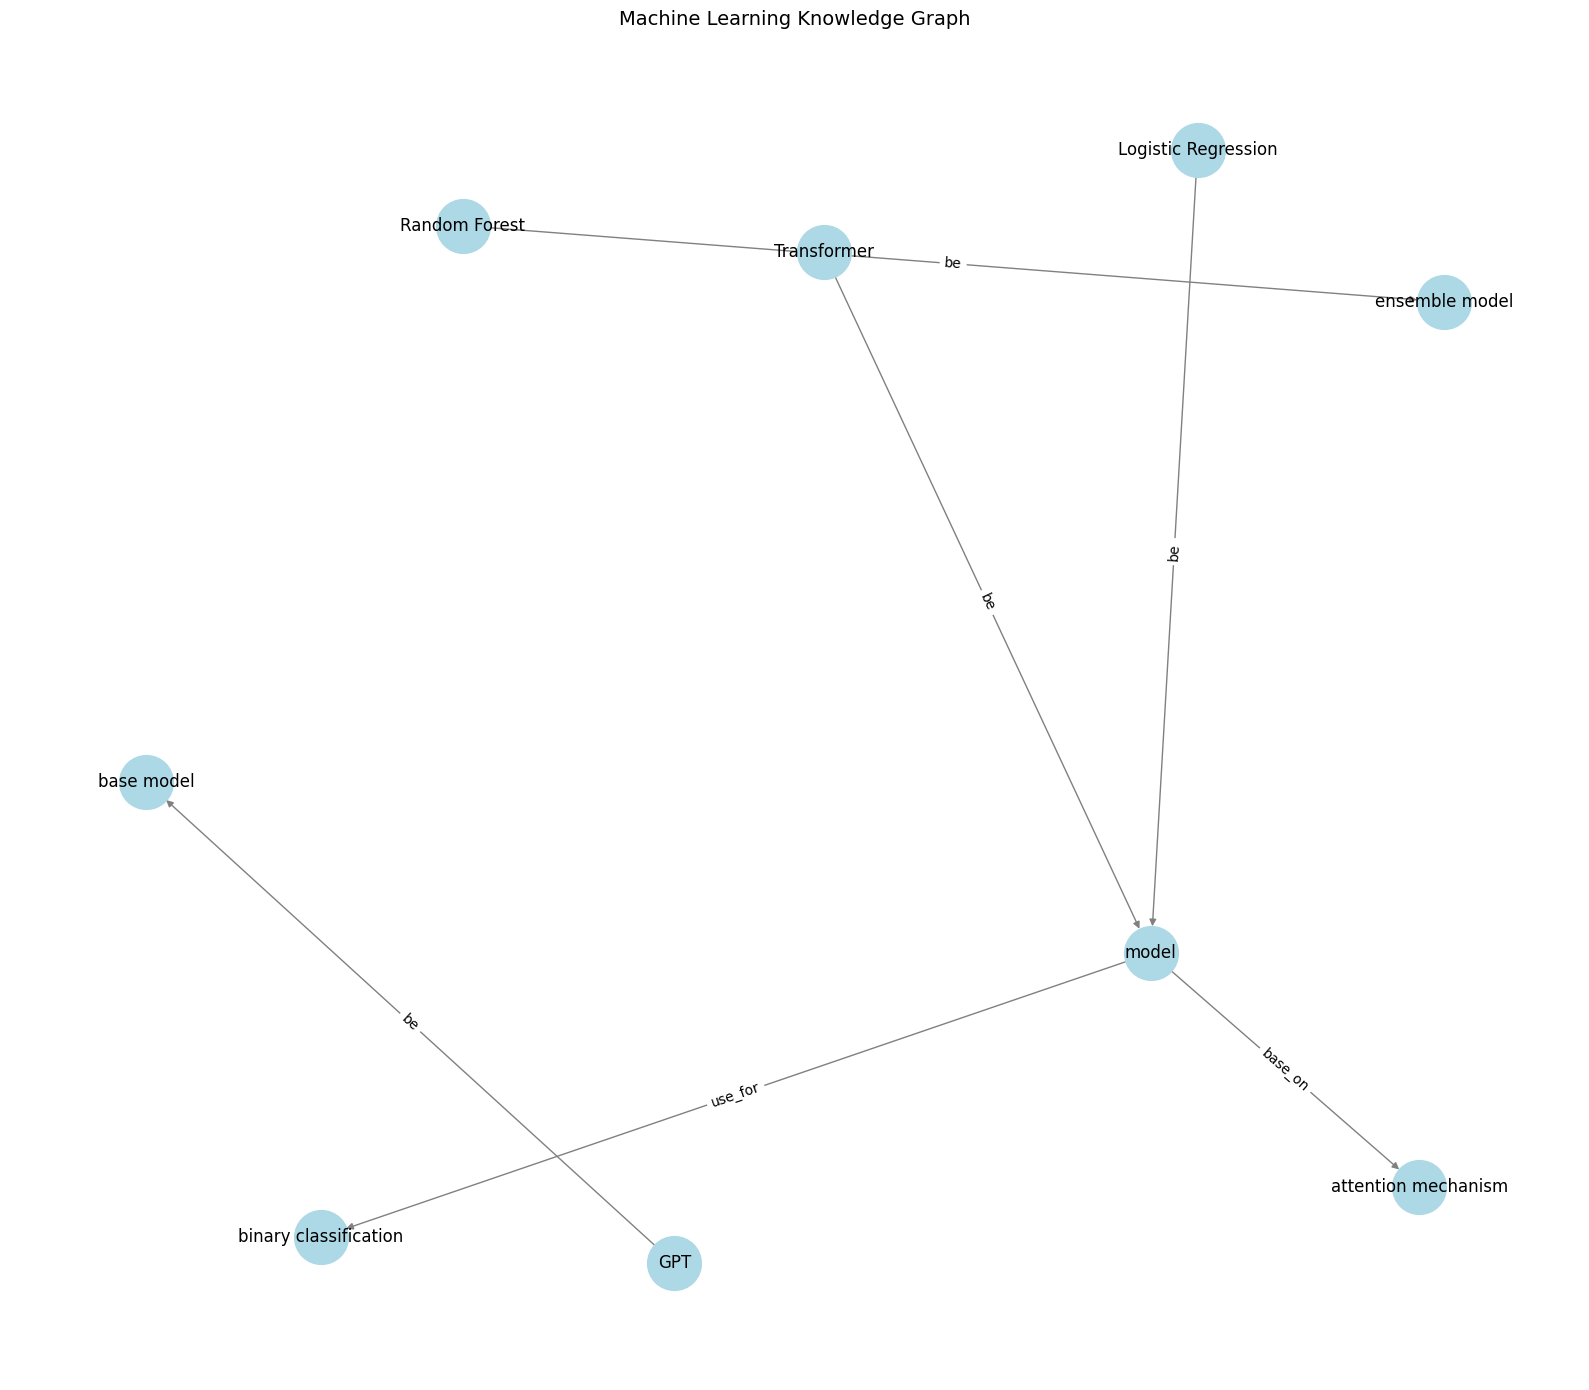

In [19]:
# レイアウト計算
pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
edge_labels = nx.get_edge_attributes(G, "relation")

# グラフ描画
fig, ax = plt.subplots(1, 1, figsize=(16, 14))

nx.draw(
    G, pos, ax=ax, with_labels=True, node_color='lightblue',
    node_size=1500, edge_color='gray'
)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels
)

ax.set_title('Machine Learning Knowledge Graph', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()